In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import torchaudio

random.seed(0)
np.random.seed(0)

In [2]:
!nvidia-smi

Fri Jun  9 18:15:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:01:00.0  On |                  N/A |
| 80%   41C    P0              141W / 350W|    915MiB / 24576MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('./data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('./data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]
train_text = pkl.load(open('./data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('./data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
go_emotions = pd.concat([train_text, test_text])

In [5]:
go_emotions.groupby("grouped_label").count()

,text
grouped_label,
anger,6039
disgust,664
fear,705
joy,19002
neutral,14429
sadness,2936
surprise,5062


In [6]:
anger = go_emotions[go_emotions["grouped_label"] == "anger"].sample(5000, replace=False, random_state=0)
disgust = go_emotions[go_emotions["grouped_label"] == "disgust"].sample(4000, replace=True, random_state=0)
fear = go_emotions[go_emotions["grouped_label"] == "fear"].sample(4000, replace=True, random_state=0)
joy = go_emotions[go_emotions["grouped_label"] == "joy"].sample(5000, replace=False, random_state=0)
neutral = go_emotions[go_emotions["grouped_label"] == "neutral"].sample(5000, replace=False, random_state=0)
sadness = go_emotions[go_emotions["grouped_label"] == "sadness"].sample(2000, replace=True, random_state=0)

In [7]:
go_emotions = go_emotions[go_emotions["grouped_label"] != "anger"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "joy"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "neutral"]
go_emotions = pd.concat([go_emotions, anger, disgust, fear, joy, neutral, sadness])
go_emotions.groupby("grouped_label").count()

,text
grouped_label,
anger,5000
disgust,4664
fear,4705
joy,5000
neutral,5000
sadness,4936
surprise,5062


In [8]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [9]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [10]:
pd.concat([train_audio,test_audio]).groupby("label").count()

,path
label,
anger,1863
disgust,1863
fear,1863
joy,2055
neutral,1583
sadness,1863
surprise,592


In [11]:
audio_datasets = pd.concat([train_audio,test_audio]).reset_index(drop=True)
surprise = audio_datasets[audio_datasets["label"] == "surprise"].sample(2000, replace=True, random_state=0)
audio_datasets = audio_datasets[audio_datasets["label"] != "surprise"]
audio_datasets = pd.concat([audio_datasets, surprise]).reset_index(drop=True)
audio_datasets

,path,label
0,./audio/audio_emo/crema.woman.happy.14.wav,joy
1,./audio/audio_emo/crema.man.afraid.341.wav,fear
2,./audio/audio_emo/crema.man.neutral.370.wav,neutral
3,./audio/audio_emo/tess.woman.sad.350.wav,sadness
4,./audio/audio_emo/crema.man.angry.448.wav,anger
...,...,...
13085,./audio/audio_emo/tess.woman.surprised.351.wav,surprise
13086,./audio/audio_emo/ravdass.man.surprise.63.wav,surprise
13087,./audio/audio_emo/tess.woman.surprised.26.wav,surprise
13088,./audio/audio_emo/tess.woman.surprised.67.wav,surprise


In [12]:
audio_datasets.groupby("label").count()

,path
label,
anger,1863
disgust,1863
fear,1863
joy,2055
neutral,1583
sadness,1863
surprise,2000


## Load Meld and IEMOCAP

In [13]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

,text,label,path
0,The only one I know still love his parents. [B...,joy,/home/vmachado/Documents/multimodal-datasets/I...
1,The only one I know still love his parents. Ye...,neutral,/home/vmachado/Documents/multimodal-datasets/I...
2,Oh it's not bad thing it's good thing. You kno...,joy,/home/vmachado/Documents/multimodal-datasets/I...
3,"You know it's nice here, the air is sweet. You...",sadness,/home/vmachado/Documents/multimodal-datasets/I...
4,"You're not sorry you came? Not sorry, no. I c...",sadness,/home/vmachado/Documents/multimodal-datasets/I...
...,...,...,...
13723,That would be no. Come on. It doesn't taste ba...,neutral,/home/vmachado/Documents/multimodal-datasets/M...
13724,"Come on. It doesn't taste bad. Yeah, it's kind...",joy,/home/vmachado/Documents/multimodal-datasets/M...
13725,"Yeah, it's kinda sweet, sorta like, uh... Cant...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
13726,Cantaloupe juice. Exactly. [BFR] You've tasted...,surprise,/home/vmachado/Documents/multimodal-datasets/M...


In [14]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

,text,label,path
0,"[BFR] Brian, I need help. [AFT] Babe, I don't...",sadness,/home/vmachado/Documents/multimodal-datasets/I...
1,"Brian, I need help. [BFR] Babe, I don't know w...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
2,"Babe, I don't know what to tell you. Don't gi...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
3,"I wish I had some answers for you, babe. I me...",neutral,/home/vmachado/Documents/multimodal-datasets/I...
4,I went to school and I got my degree. And I g...,neutral,/home/vmachado/Documents/multimodal-datasets/I...
...,...,...,...
3846,"Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!",neutral,/home/vmachado/Documents/multimodal-datasets/M...
3847,It isn't. It is. [BFR] Isn't! [AFT],anger,/home/vmachado/Documents/multimodal-datasets/M...
3848,[BFR] Yeah baby! [AFT] I’m really glad you gu...,joy,/home/vmachado/Documents/multimodal-datasets/M...
3849,Yeah baby! [BFR] I’m really glad you guys are ...,neutral,/home/vmachado/Documents/multimodal-datasets/M...


In [15]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

,text,label,path,source
0,"[BFR] Brian, I need help. [AFT] Babe, I don't...",sadness,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
1,"Brian, I need help. [BFR] Babe, I don't know w...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
2,"Babe, I don't know what to tell you. Don't gi...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
3,"I wish I had some answers for you, babe. I me...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
4,I went to school and I got my degree. And I g...,neutral,/home/vmachado/Documents/multimodal-datasets/I...,iemocap
...,...,...,...,...
3846,"Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!",neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld
3847,It isn't. It is. [BFR] Isn't! [AFT],anger,/home/vmachado/Documents/multimodal-datasets/M...,meld
3848,[BFR] Yeah baby! [AFT] I’m really glad you gu...,joy,/home/vmachado/Documents/multimodal-datasets/M...,meld
3849,Yeah baby! [BFR] I’m really glad you guys are ...,neutral,/home/vmachado/Documents/multimodal-datasets/M...,meld


In [16]:
test_df_erc.groupby("source").count()

,text,label,path
source,,,
iemocap,1241,1241,1241
meld,2610,2610,2610


## Join datasets

In [17]:
train_df_erc.groupby("label").count()

,text,path
label,,
anger,1954,1954
disgust,258,258
fear,266,266
joy,2783,2783
neutral,5804,5804
sadness,1451,1451
surprise,1212,1212


In [18]:
ang = train_df_erc[train_df_erc["label"] == "anger"].sample(1700, replace=True, random_state=0)
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(4700, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(4700, replace=True, random_state=0)
joy = train_df_erc[train_df_erc["label"] == "joy"].sample(2300, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(3500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(3500, replace=True, random_state=0)

In [19]:
train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness]).reset_index(drop=True)

In [20]:
train_df_erc_resampled.groupby("label").count()

,text,path
label,,
anger,3654,3654
disgust,4958,4958
fear,4966,4966
joy,5083,5083
neutral,5804,5804
sadness,4951,4951
surprise,4712,4712


## Librispeech

In [21]:
#librispeech = torchaudio.datasets.LIBRISPEECH("./", 'train-clean-100', download=True)

In [22]:
#len(librispeech)

In [23]:
"""
from tqdm import tqdm
ls = []
!mkdir librispeech_wavs

for i in tqdm(range(len(librispeech))):
    wf, sr, tx, _, _, _ = librispeech.__getitem__(i)
    path = f'librispeech_wavs/ls_{i}.wav'
    torchaudio.save(path, wf, 16000)
    ls.append({
        "path": path,
        "text": tx,
        "label": None
    })
"""

'\nfrom tqdm import tqdm\nls = []\n!mkdir librispeech_wavs\n\nfor i in tqdm(range(len(librispeech))):\n    wf, sr, tx, _, _, _ = librispeech.__getitem__(i)\n    path = f\'librispeech_wavs/ls_{i}.wav\'\n    torchaudio.save(path, wf, 16000)\n    ls.append({\n        "path": path,\n        "text": tx,\n        "label": None\n    })\n'

In [24]:
df_ls = pd.read_csv("df_ls.csv")
df_ls

,path,text,label
0,librispeech_wavs/ls_0.wav,CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...,NaN
1,librispeech_wavs/ls_1.wav,THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...,NaN
2,librispeech_wavs/ls_2.wav,FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...,NaN
3,librispeech_wavs/ls_3.wav,AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...,NaN
4,librispeech_wavs/ls_4.wav,BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...,NaN
...,...,...,...
28534,librispeech_wavs/ls_28534.wav,HE PUT AN ARROW THROUGH IT AND IT TURNED A SOM...,NaN
28535,librispeech_wavs/ls_28535.wav,AND RAN AWAY THEN THE BOY CLIMBED DOWN FROM TH...,NaN
28536,librispeech_wavs/ls_28536.wav,A MAN SUDDENLY STOOD BEFORE HIM AND ASKED WHAT...,NaN
28537,librispeech_wavs/ls_28537.wav,AND THEN WHIP THE BODY WITH A MERAL TWIG AND H...,NaN


In [25]:
#from joblib import Parallel, delayed
#_ = Parallel(n_jobs=12)(delayed(get_data_cluster)(x) for x in df_ls["path"])

## Join all datasets

In [26]:
df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
#df_train = pd.concat([audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled,train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")

df_train

,text,label,path
0,To make her feel threatened,fear,None
1,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,surprise,None
2,Demographics? I don’t know anybody under 35 wh...,surprise,None
3,Maybe that’s what happened to the great white ...,surprise,None
4,"I never thought it was at the same moment, but...",surprise,None
...,...,...,...
110119,HE PUT AN ARROW THROUGH IT AND IT TURNED A SOM...,NaN,librispeech_wavs/ls_28534.wav
110120,AND RAN AWAY THEN THE BOY CLIMBED DOWN FROM TH...,NaN,librispeech_wavs/ls_28535.wav
110121,A MAN SUDDENLY STOOD BEFORE HIM AND ASKED WHAT...,NaN,librispeech_wavs/ls_28536.wav
110122,AND THEN WHIP THE BODY WITH A MERAL TWIG AND H...,NaN,librispeech_wavs/ls_28537.wav


In [27]:
df_train.groupby("label").count()

,text,path
label,,
anger,8654,5517
disgust,9622,6821
fear,9671,6829
joy,10083,7138
neutral,10804,7387
sadness,9887,6814
surprise,9774,6712


In [28]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(train_df_erc_resampled['label'].unique())

LabelEncoder()

In [29]:
len(df_train)

110124

In [30]:
len(test_df_erc)

3851

In [31]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [32]:
import torch
torch.manual_seed(0)
import torch.nn as nn

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.2, contrast_mode='all',
                 base_temperature=0.2):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None, temperature=None, base_temperature=None, weights=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        if temperature == None:
            temperature = self.temperature
        if base_temperature == None:
            base_temperature = self.base_temperature
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (temperature/base_temperature) * mean_log_prob_pos
        
        if anchor_count == 1:
            loss = loss.view(anchor_count, batch_size)
        else:
            assert anchor_count == 2 and weights != None
            loss = loss.view(anchor_count * batch_size)
            loss = loss * weights
        return loss.mean()

In [33]:
from transformers import AutoTokenizer, AutoModel

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


class TextEncoder(nn.Module):

    def __init__(self, model_name, max_len):
        super(TextEncoder, self).__init__()

        self.max_len = max_len
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        _ = self.tokenizer.add_tokens(['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFR]', '[AFT]'], special_tokens=True)
        self.encoder = AutoModel.from_pretrained(model_name)
        self.encoder.resize_token_embeddings(len(self.tokenizer))
 
    def forward(self, sentences):
        
        tokenized = self.tokenizer(sentences, padding='max_length', truncation=True, return_tensors='pt', max_length=self.max_len)
        
        att_mask = tokenized["attention_mask"].to(0)
        tokenized = {
            "input_ids":tokenized["input_ids"].to(0),
            "attention_mask": att_mask
        }
        out = self.encoder(**tokenized)
        
        out = mean_pooling(out, att_mask)
        #out = out[:, 0, :]
        return out

## MFCC Extractor and KMeans Hidden units

In [34]:
import hashlib
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import numpy as np
from tqdm import tqdm
import functools
import math
import pickle as pkl
import os

sample_rate = 16000
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

MFCC_PARAMS = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

PITCH_PARAMS = {
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "sample_rate": sample_rate,
}

def get_feats(x, sr, max_pool_window_size=4, params=MFCC_PARAMS, params_pitch=PITCH_PARAMS):
    pitch = torchaudio.functional.compute_kaldi_pitch(x, **params_pitch).squeeze(dim=0)
    
    x = x.view(1, -1)

    mfccs = torchaudio.compliance.kaldi.mfcc(
        x,
        **params
    )  # (time, freq)
    
    try:
        mfccs = torch.cat([mfccs, pitch], dim=-1)
    except:
        mfccs = torch.cat([mfccs, torch.Tensor(np.zeros((mfccs.shape[0], 2)))], dim=-1)
    
    mfccs_z = torch.Tensor(np.zeros(((mfccs.shape[0] // max_pool_window_size) + 1, mfccs.shape[1])))
    
    for i in range(len(mfccs) // max_pool_window_size): # Max pooling over time to reduce sequence size
        mfcc_win = mfccs[i * max_pool_window_size:(i + 1) * max_pool_window_size]
        norms = [np.linalg.norm(v[:-2]) for v in mfcc_win]
        argmax = np.argmax(np.array(norms))
        mfccs_z[i] = mfcc_win[argmax]
            
    mfccs = mfccs_z.transpose(0, 1)  # (freq, time)
    deltas = torchaudio.functional.compute_deltas(mfccs)
    ddeltas = torchaudio.functional.compute_deltas(deltas)
    concat = torch.cat([mfccs, deltas, ddeltas], dim=0)
    concat = concat.transpose(0, 1).contiguous()
    
    return concat

def mfcc_feature_extractor(path, desired_sr=16000, cache="./preprocessed_audio_cache_new"):
    hashed_name = hashlib.md5(path.encode('utf-8')).hexdigest()
    hashed_path = cache + '/' + f"{hashed_name}.bin"
    with torch.no_grad():
        if os.path.isfile(hashed_path):
            return torch.load(hashed_path)
        else:
            waveform, sample_rate = torchaudio.load(path, normalize=True, channels_first=True)
            waveform = waveform.float()
                
            if len(waveform.shape) == 2:
                waveform = torch.mean(waveform, dim=0).unsqueeze(dim=0)

            if sample_rate != desired_sr:
                transform = torchaudio.transforms.Resample(sample_rate, desired_sr)
                waveform = transform(waveform)

            mfcc = get_feats(waveform, desired_sr)
            torch.save(mfcc, hashed_path)
            return mfcc

In [35]:
def get_data_cluster(path):
    mfcc_audio = mfcc_feature_extractor(path)
    return mfcc_audio

In [36]:
get_data_cluster("./audio/audio_emo/tess.woman.sad.5.wav")

tensor([[-5.4309e+01, -3.1988e+01, -7.8407e+00,  ...,  5.5061e-01,
          3.8081e-03, -4.5475e-14],
        [-4.4171e+01, -3.9444e+01,  5.1471e+00,  ...,  4.6405e-01,
         -3.2662e-04, -4.5475e-14],
        [-3.8823e+01, -5.1685e+01,  8.3763e+00,  ..., -6.5955e-01,
          1.7061e-02, -4.5475e-14],
        ...,
        [-6.4814e+01, -1.1119e+01,  1.3244e+01,  ..., -9.4502e-01,
         -4.3116e-02, -1.9203e+01],
        [-6.6382e+01, -1.6293e+01,  1.4263e+01,  ..., -2.1900e-01,
         -4.5776e-02, -1.4936e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.0201e-01,
         -9.7358e-03, -4.2674e+00]])

## Add mask to Transformer, try learned positional embeddings

In [37]:
from joblib import Parallel, delayed

class AudioEncoderMFCCHUTokenizer(object):
    
    def __init__(self, max_length, mean, std):
        self.max_length = max_length
        self.mean = mean
        self.std = std
        
    def tokenize(self, path):
        with torch.no_grad():
            mfcc = (mfcc_feature_extractor(path) - self.mean) / (self.std + 1e-10)
        
            l = len(mfcc)
            att_mask = torch.ones((self.max_length, 1))

            if l > self.max_length:
                mfcc = mfcc[:self.max_length]
            elif l < self.max_length:
                mask_idx = torch.Tensor([i + l for i in range(self.max_length - l)]).long()
                att_mask = att_mask.index_fill_(0, mask_idx, 0.0)
                repeat = torch.zeros((self.max_length - l, mfcc.shape[1]))
                mfcc = torch.cat([mfcc, repeat], dim=0)

            mfcc = mfcc.unsqueeze(dim=0)
            att_mask = att_mask.unsqueeze(dim=0).squeeze(dim=-1)
            return mfcc, att_mask
    
    def batch_tokenize(self, paths, n_jobs=12):
        X = Parallel(n_jobs=n_jobs)(delayed(self.tokenize)(x) for x in paths)
        mfccs = [m for m, _ in X]
        att_masks = [a for _, a in X]
        mfccs = torch.cat(mfccs, dim=0)
        att_masks = torch.cat(att_masks, dim=0)
        return mfccs, att_masks

In [38]:
from vector_quantize_pytorch import VectorQuantize, GroupedResidualVQ
from vector_quantize_pytorch import ResidualVQ

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class AudioEncoderMFCCHU(nn.Module):

    def __init__(self, 
                 vocab_size,
                 emb_dim=768, 
                 n_layers=6, 
                 max_length=800,
                 raw_features_size=45,
                 nheads=8, 
                 dropout=0.2):
        super(AudioEncoderMFCCHU, self).__init__()
        
        self.vocab_size = vocab_size
        
        self.max_length = max_length
        
        self.vq = ResidualVQ(
            dim = raw_features_size,
            codebook_size = self.vocab_size,
            codebook_dim = 128,
            num_quantizers = 4,
            threshold_ema_dead_code = 2,
        )
            
        self.pos_encoder = PositionalEncoding(emb_dim, dropout=0.0)
        self.project = nn.Sequential(nn.Linear(raw_features_size, emb_dim), nn.GELU(), nn.Linear(emb_dim, emb_dim))
        self.emb_dim = emb_dim
        self.dropout = dropout
        self.transf_layer = nn.TransformerEncoderLayer(d_model=emb_dim, dim_feedforward=emb_dim*4, nhead=nheads, batch_first=True, norm_first=True, dropout=self.dropout)
        self.transf_enc = nn.TransformerEncoder(self.transf_layer, num_layers=n_layers, norm=None)
        
        self.norm_feats = nn.LayerNorm(raw_features_size)

    def forward(self, features, attn_masks):
        
        features = self.norm_feats(features)
        qtz_feats, _, vq_loss = self.vq(features)
        vq_loss = vq_loss.mean()
            
        seq_lens = 1 / torch.sum(attn_masks, dim=-1)
        seq_lens = seq_lens.unsqueeze(dim=0).T

        x = self.project(qtz_feats)
        x = self.pos_encoder(x)

        x = self.transf_enc(x, src_key_padding_mask=attn_masks)
        x = seq_lens * torch.sum(x, dim=1)
        
        return x, vq_loss

In [39]:
class AudioTextCLIP(nn.Module):

    def __init__(self, 
                 text_encoder, 
                 audio_encoder, 
                 freeze_text_enc=False, 
                 freeze_audio_enc=False, 
                 in_features_text=384, 
                 in_features_audio=16, 
                 wide_proj=1024, 
                 proj_size=128,
                 hidden_size=384,
                 rate=0.1,):
        super(AudioTextCLIP, self).__init__()
        
        self.audio_encoder = audio_encoder
        self.text_encoder = text_encoder

        if freeze_text_enc:
            for i, (name, param) in enumerate(list(self.text_encoder.named_parameters())):
                param.requires_grad = False
            
        if freeze_audio_enc:
            for i, (name, param) in enumerate(list(self.audio_encoder.named_parameters())):
                param.requires_grad = False

        self.mods_proj = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.GELU(), nn.Dropout(p=rate), nn.Linear(hidden_size, wide_proj))
        self.text_proj = nn.Sequential(self.text_encoder, nn.Linear(in_features_text, hidden_size),  nn.GELU(), nn.Dropout(p=rate), nn.Linear(hidden_size, hidden_size), nn.GELU(), self.mods_proj)
        self.audio_proj = nn.Sequential(nn.Linear(in_features_audio, hidden_size), nn.GELU(), nn.Dropout(p=rate), nn.Linear(hidden_size, hidden_size), nn.GELU(), self.mods_proj)
        self.linear = nn.Linear(wide_proj, proj_size)
        
        self.alpha = nn.Sequential(nn.Linear(wide_proj, wide_proj), nn.GELU(), nn.Dropout(p=rate), nn.Linear(wide_proj, 1))
        
        self.rate = rate
        
    def forward(self, inp):

        sentences, audio_input, multimodal = inp
        
        assert sentences != None or audio_input != None or multimodal != None
        
        x_text = None
        x_text_wide = None
        if sentences != None:
            x_text_wide = F.normalize(self.text_proj(sentences), dim=-1)
            x_text = F.normalize(self.linear(x_text_wide), dim=-1)
            
        x_audio = None
        x_audio_wide = None
        if audio_input != None:
            x_audio_wide, _ = self.audio_encoder(**audio_input)
            x_audio_wide = F.normalize(self.audio_proj(x_audio_wide), dim=-1)
            x_audio = F.normalize(self.linear(x_audio_wide), dim=-1)
        
        x_mult_text = None
        x_mult_text_wide = None
        x_mult_audio = None
        x_mult_audio_wide = None
        
        # Approximate text and audio, and make sum of vectors point to correct cls
        if multimodal != None:
            x_mult_text = F.normalize(self.text_proj(multimodal['sentences']), dim=-1)
            x_mult_text_alpha = self.alpha(x_mult_text)
            
            x_mult_audio, _ = self.audio_encoder(**multimodal['audio_input'])
            x_mult_audio = F.normalize(self.audio_proj(x_mult_audio), dim=-1)
            x_mult_audio_alpha = self.alpha(x_mult_audio)
            
            alphas = F.softmax(torch.cat([x_mult_text_alpha, x_mult_audio_alpha], dim=-1), dim=-1).unsqueeze(dim=1)

            # View 1
            x_mult_text_wide = alphas[:, :, 1] * x_mult_text
            x_mult_text = alphas[:, :, 1] * F.normalize(self.linear(x_mult_text), dim=-1)
            
            # View 2
            x_mult_audio_wide = alphas[:, :, 0] * x_mult_audio
            x_mult_audio = alphas[:, :, 0] * F.normalize(self.linear(x_mult_audio), dim=-1)

        return {
            "x_text": x_text,
            "x_text_wide": x_text_wide,
            "x_audio": x_audio,
            "x_audio_wide": x_audio_wide,
            "x_mult_text": x_mult_text,
            "x_mult_text_wide": x_mult_text_wide,
            "x_mult_audio": x_mult_audio,
            "x_mult_audio_wide": x_mult_audio_wide,
        }

In [40]:
df_train['label'].unique()

array(['fear', 'surprise', 'sadness', 'disgust', 'anger', 'joy',
       'neutral', nan], dtype=object)

In [41]:
import torchaudio
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [42]:
gc.collect()

0

In [43]:
import numpy as np
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [44]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

global PREVIOUS_LR
PREVIOUS_LR = -9999
def calc_lr(step, dim_embed, warmup_steps):
    #if step > warmup_steps:
    #    return 5e-5
    global PREVIOUS_LR
    lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
    if lr < 2e-4:
        PREVIOUS_LR = lr
        return lr
    else:
        lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        while lr >= PREVIOUS_LR:
            step += 1.
            lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        PREVIOUS_LR = lr
        return lr

In [45]:
dim_embed = 768
N_VECTORS = 100
MAX_LEN = 128

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=3, 
    max_length=MAX_LEN, 
    nheads=8,
    dropout=0.1
)

audio_encoder = torch.load(f'audio_encoder_best/audio_encoder.bin')
#audio_encoder.load_state_dict(torch.load(f'audio_encoder_pre_trained_reformed_5_FIM_6_layer_continue/audio_best.bin'))

In [46]:
MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
text_encoder = TextEncoder(MODEL_NAME, max_len=128)
text_encoder.load_state_dict(torch.load('text_encoder_only_meld/dabest_text.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/best_text_encoder.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/pytorch_model_AudioTextCLIP_epoch_22.bin'))

<All keys matched successfully>

In [47]:
mean = torch.Tensor([-2.4002e+01, -5.4726e+00, -1.1825e+01,  6.6728e-01, -1.6782e+01,
        -7.0169e+00, -1.4942e+01, -7.5624e+00, -7.5826e+00, -2.1841e+00,
        -6.0805e+00, -3.0830e+00, -5.6635e+00,  1.9363e-01,  2.0110e+02,
         7.1090e-01,  2.1245e-01,  1.8659e-01,  1.7632e-02,  3.0055e-01,
         5.8593e-02,  2.2993e-01,  1.1659e-01,  1.2025e-01,  6.4304e-03,
         1.1272e-01,  5.9370e-02,  1.0354e-01, -7.5894e-03, -4.8167e+00,
         2.0838e-01,  5.0690e-02,  1.0683e-01,  1.4690e-02,  1.4356e-01,
         6.8523e-02,  1.3284e-01,  6.2631e-02,  6.9484e-02,  3.4108e-02,
         5.7172e-02,  4.1190e-02,  4.6194e-02, -1.4585e-03, -1.8164e+00])
std = torch.Tensor([1.4204e+01, 1.3486e+01, 1.7198e+01, 1.7307e+01, 1.7100e+01, 1.7898e+01,
        1.7963e+01, 1.7448e+01, 1.7087e+01, 1.7854e+01, 1.5724e+01, 1.5907e+01,
        1.4398e+01, 4.2155e-01, 9.8201e+01, 3.8302e+00, 4.1511e+00, 4.9767e+00,
        5.4117e+00, 5.3979e+00, 5.6093e+00, 5.7001e+00, 5.3550e+00, 5.4432e+00,
        5.3551e+00, 4.9909e+00, 4.8445e+00, 4.4496e+00, 1.3624e-01, 1.9747e+01,
        1.5212e+00, 1.8603e+00, 2.2115e+00, 2.4687e+00, 2.3968e+00, 2.5010e+00,
        2.5413e+00, 2.3874e+00, 2.4448e+00, 2.3907e+00, 2.2411e+00, 2.1623e+00,
        1.9933e+00, 6.0878e-02, 6.4246e+00])

audio_tokenizer = AudioEncoderMFCCHUTokenizer(MAX_LEN, mean, std)

In [48]:
gc.collect()

27

# Save adio encoder again

In [49]:
#torch.save(supcon_model.audio_encoder, f'audio_encoder_best/audio_encoder.bin')

In [50]:
#torch.norm(out["x_mult_text"] + out["x_mult_audio"], dim=-1)

100%|████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.94s/it]


Cosine Similarity between mods: 0.15632336581103123
General - KNN F1: 0.6443730256003578 Acc: 0.6439885743962607
Iemocap - KNN F1: 0.7586155715606969 Acc: 0.750201450443191
Meld - KNN F1: 0.5907582741863512 Acc: 0.5934865900383142
Iemocap - KNN F1 (macro): 0.6058575400341271
Meld - KNN F1 (macro): 0.41612400259547017


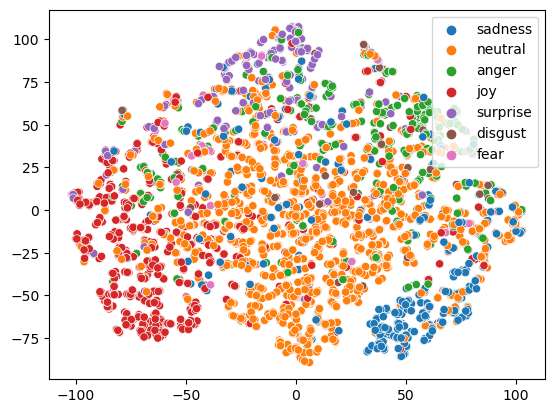

Epoch: 1 - Train Loss: 5.60150729726862


100%|████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.94s/it]


Cosine Similarity between mods: 0.3113934822250917
General - KNN F1: 0.6479282696624145 Acc: 0.6455466112698001
Iemocap - KNN F1: 0.7637134928122868 Acc: 0.7566478646253022
Meld - KNN F1: 0.5944422032637713 Acc: 0.59272030651341
Iemocap - KNN F1 (macro): 0.6100025524806129
Meld - KNN F1 (macro): 0.4121683108935393


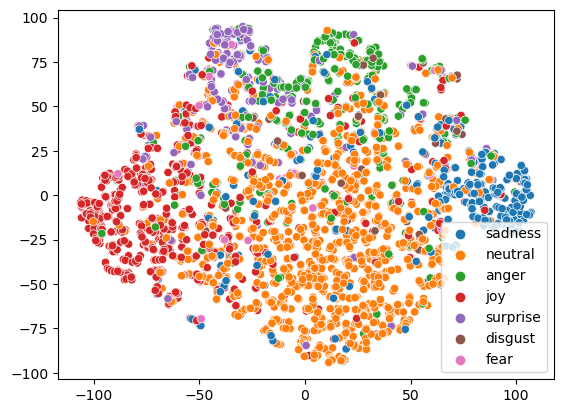

Epoch: 2 - Train Loss: 5.283023079236348


100%|████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.88s/it]


Cosine Similarity between mods: 0.4277014721216892
General - KNN F1: 0.6532248735353544 Acc: 0.6509997403271878
Iemocap - KNN F1: 0.7684233756724314 Acc: 0.7622884770346495
Meld - KNN F1: 0.6000391424410215 Acc: 0.5980842911877394
Iemocap - KNN F1 (macro): 0.6137922099376331
Meld - KNN F1 (macro): 0.4233993561228235


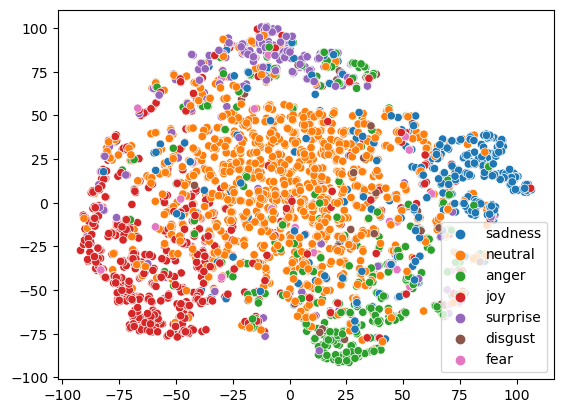

Epoch: 3 - Train Loss: 5.195406904927006


100%|████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.65s/it]


Cosine Similarity between mods: 0.421945877491236
General - KNN F1: 0.6563540308960477 Acc: 0.6538561412620099
Iemocap - KNN F1: 0.7758035504062601 Acc: 0.7679290894439967
Meld - KNN F1: 0.6004075096024212 Acc: 0.5996168582375478
Iemocap - KNN F1 (macro): 0.6230023121859554
Meld - KNN F1 (macro): 0.41282282664059683


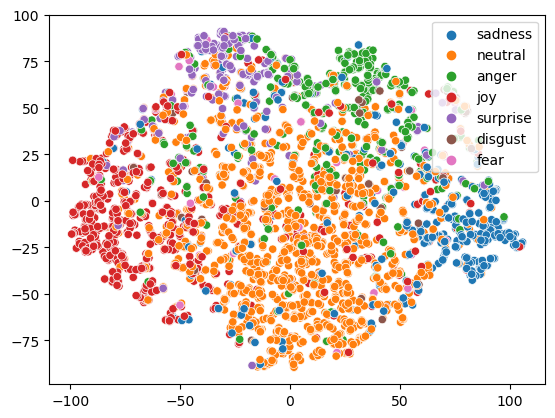

Epoch: 4 - Train Loss: 5.1283140756465775


100%|████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.91s/it]


Cosine Similarity between mods: 0.4685650560274523
General - KNN F1: 0.6591370260477378 Acc: 0.6574915606336017
Iemocap - KNN F1: 0.7730874412873602 Acc: 0.7679290894439967
Meld - KNN F1: 0.606868561256647 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6180028901620951
Meld - KNN F1 (macro): 0.42748479179943333


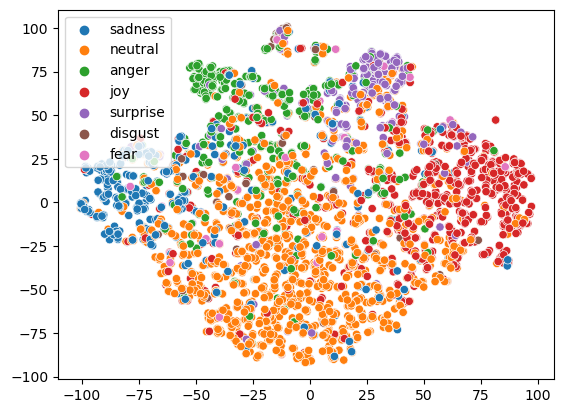

Epoch: 5 - Train Loss: 5.094160207995662


100%|████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.79s/it]


Cosine Similarity between mods: 0.4465153728079963
General - KNN F1: 0.6613256357445723 Acc: 0.6611269800051934
Iemocap - KNN F1: 0.7824497455681192 Acc: 0.7792103142626914
Meld - KNN F1: 0.6039288558320542 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6261645420177003
Meld - KNN F1 (macro): 0.41730640539647623


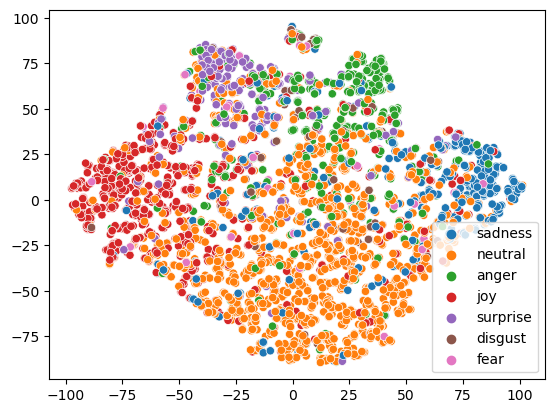

Epoch: 6 - Train Loss: 5.045156116838808


100%|████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.90s/it]


Cosine Similarity between mods: 0.46500513418034684
General - KNN F1: 0.6547394191437275 Acc: 0.6556738509478057
Iemocap - KNN F1: 0.7902100554863491 Acc: 0.7912973408541499
Meld - KNN F1: 0.5911226401274117 Acc: 0.5911877394636015
Iemocap - KNN F1 (macro): 0.6327250695473547
Meld - KNN F1 (macro): 0.40818474602974847


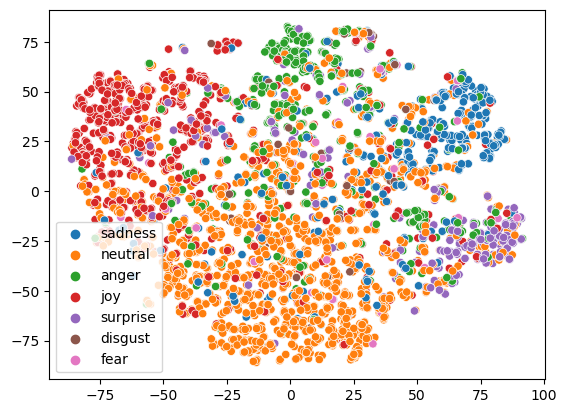

Epoch: 7 - Train Loss: 5.021313128647981


100%|████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.07s/it]


Cosine Similarity between mods: 0.4938768155541986
General - KNN F1: 0.6637894747944842 Acc: 0.6676188003116074
Iemocap - KNN F1: 0.795110481361983 Acc: 0.7921031426269137
Meld - KNN F1: 0.600688772652747 Acc: 0.6084291187739463
Iemocap - KNN F1 (macro): 0.6365404916088482
Meld - KNN F1 (macro): 0.41444878406493924


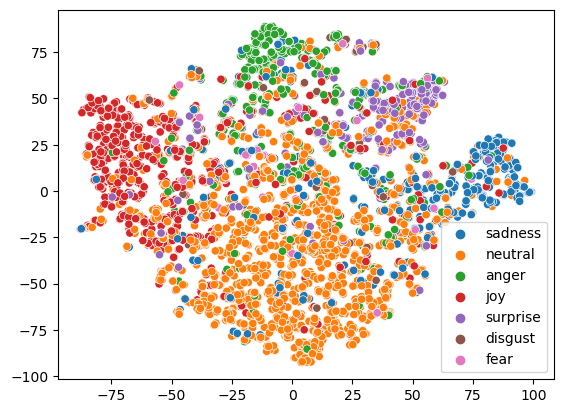

Epoch: 8 - Train Loss: 4.991841753323873


100%|████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.06s/it]


Cosine Similarity between mods: 0.482516573794753
General - KNN F1: 0.6563361349363349 Acc: 0.659049597507141
Iemocap - KNN F1: 0.7816692101335204 Acc: 0.7816277195809831
Meld - KNN F1: 0.5942681966208969 Acc: 0.6007662835249042
Iemocap - KNN F1 (macro): 0.6254152312611735
Meld - KNN F1 (macro): 0.40999633754551656


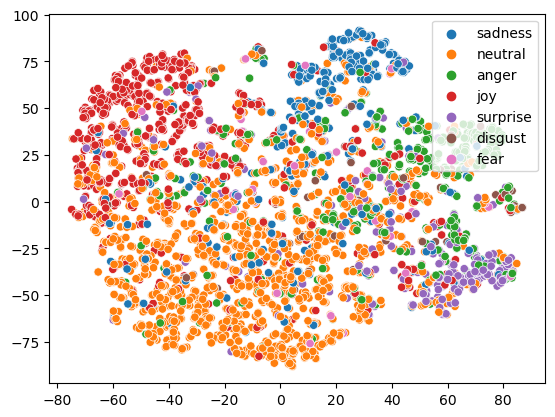

Epoch: 9 - Train Loss: 4.96589489336367


100%|████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.58s/it]


Cosine Similarity between mods: 0.4813276403323609
General - KNN F1: 0.6559676372183282 Acc: 0.6577512334458582
Iemocap - KNN F1: 0.7742995019268885 Acc: 0.7687348912167606
Meld - KNN F1: 0.598622926930545 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6186312227590919
Meld - KNN F1 (macro): 0.4155675798650301


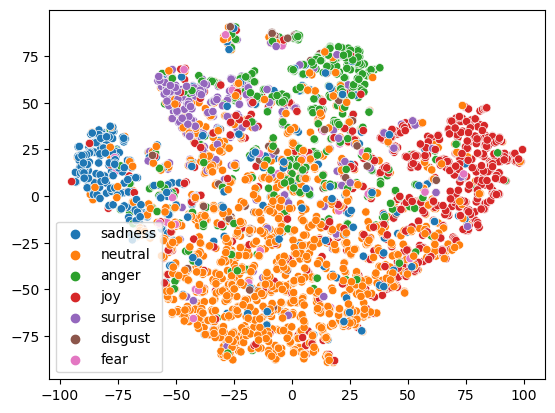

Epoch: 10 - Train Loss: 4.93905751351957


100%|████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.62s/it]


Cosine Similarity between mods: 0.48448726760044064
General - KNN F1: 0.6508198082982393 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.769610578129638 Acc: 0.7663174858984689
Meld - KNN F1: 0.5912203681879525 Acc: 0.6
Iemocap - KNN F1 (macro): 0.6155132252023424
Meld - KNN F1 (macro): 0.4069505758942307


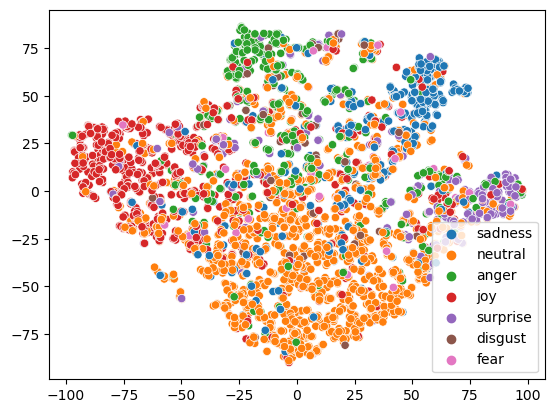

Epoch: 11 - Train Loss: 4.925425092379252


100%|████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.58s/it]


Cosine Similarity between mods: 0.5124264947162669
General - KNN F1: 0.6506069768519144 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.7731995504798524 Acc: 0.7711522965350524
Meld - KNN F1: 0.5900900070852878 Acc: 0.5977011494252874
Iemocap - KNN F1 (macro): 0.6184691092463089
Meld - KNN F1 (macro): 0.4082140550775201


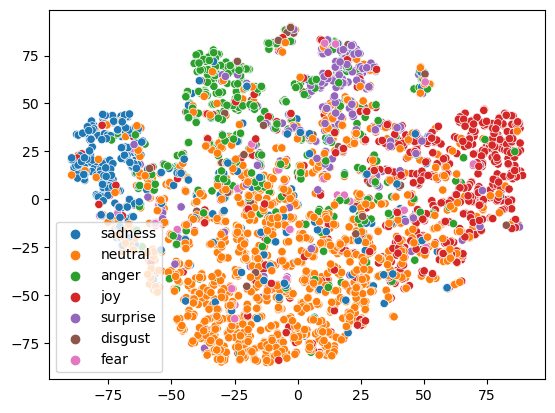

Epoch: 12 - Train Loss: 4.894509244848181


100%|████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.56s/it]


Cosine Similarity between mods: 0.499609492283863
General - KNN F1: 0.6466679274227533 Acc: 0.6478836665801091
Iemocap - KNN F1: 0.7555353833227514 Acc: 0.750201450443191
Meld - KNN F1: 0.5936631897664004 Acc: 0.5992337164750958
Iemocap - KNN F1 (macro): 0.6059892435545381
Meld - KNN F1 (macro): 0.4118828178329101


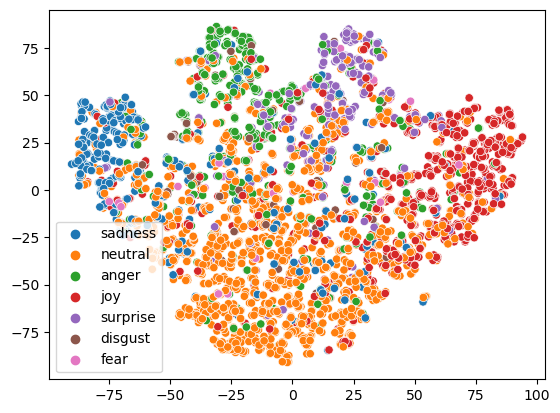

Epoch: 13 - Train Loss: 4.874875430707578


  1%|▌                                                     | 1/108 [00:03<05:52,  3.30s/it]


KeyboardInterrupt: 

In [51]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_6'
!mkdir -p {PATH_TO_SAVE}

supcon_model = AudioTextCLIP(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    freeze_text_enc=True,
    freeze_audio_enc=False,
    rate=0.1,
)

# Grid search best temperatures
# Try to only fine tune on evaluation datasets
#supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

supcon_loss = SupConLoss(temperature=0.2, contrast_mode='all', base_temperature=0.2)
supcon_loss_intra = SupConLoss(temperature=0.8, contrast_mode='all', base_temperature=0.8)

supcon_model.to(0)

scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

scheduler_epochs = 5
opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=0, betas=(0.9, 0.98), eps=1e-8)

scheduler = Scheduler(opt, 768, 600)

epochs = 9999

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []

    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if i == len(train_loader)-1:
            continue
        batch = df_train.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))

        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()
        try:
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.to(0),
                "attn_masks": att.to(0),
            }
        except:
            audio_input = None

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))
        
        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()].reset_index(drop=True)
        
        mult_not_na_idx = mult[mult["label"].notna()].index
        mult_na_idx = mult[mult["label"].isna()].index
        
        y_mult = torch.Tensor(lab_encoder.transform(mult.iloc[mult_not_na_idx]["label"]))
        
        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]
        
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)
        
        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]
        
        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}
        
        target = torch.cat([y_text, y_audio, y_mult])
        
        x = [sentences, audio_input, multimodal]
        
        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            
            out = supcon_model(x)
            
            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                weights = torch.cat([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)])
                
                if np.random.rand() < 0.5:
                    x_mult = F.normalize(x_mult_text[mult_not_na_idx] + x_mult_audio[mult_not_na_idx], dim=-1)
                    #x_mult = x_mult_text[mult_not_na_idx] + x_mult_audio[mult_not_na_idx]
                else:
                    x_mult = F.normalize(x_mult_audio[mult_not_na_idx], dim=-1)
                        
                x_mult_wide = F.normalize(out["x_mult_text_wide"][mult_not_na_idx] + out["x_mult_audio_wide"][mult_not_na_idx], dim=-1)
                
                # Add weighted contrastive loss ?
                x_mult_text = F.normalize(x_mult_text, dim=-1).unsqueeze(dim=1)
                x_mult_audio = F.normalize(x_mult_audio, dim=-1).unsqueeze(dim=1)
                mult = torch.cat([x_mult_text, x_mult_audio], dim=1)
                
                out_x, out_x_wide = None, None
                
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide], dim=0)
                elif x[1] is not None:
                    out_x = torch.cat([out["x_audio"], x_mult], dim=0).unsqueeze(dim=1)
                    out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide], dim=0)
                else:
                    out_x = x_mult.unsqueeze(dim=1)
                    out_x_wide = x_mult_wide
                
                # fera ta
                loss = 0.8 * supcon_loss(out_x, labels=target) + 0.2 * supcon_loss_intra(mult, weights=weights)
            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")
                        
                loss = supcon_loss(out_x, labels=target)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 30.0)
        scaler.step(opt)
        scheduler.step()
        scaler.update()
        
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(out_x_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out_x
        del x_mult
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    supcon_model.eval()
    preds = []
    targets = []
    css = 0.0
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            multimodal_batch = test_df_erc.iloc[batch_indices[0]]

            audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
            mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

            sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

            multimodal = {'sentences': sentences_mult, 
                          'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}
        
            target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

            x = [None, None, multimodal]
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                out = supcon_model(x)
            
            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            
            cs = F.cosine_similarity(F.normalize(out["x_mult_text_wide"], dim=-1), F.normalize(out["x_mult_audio_wide"], dim=-1))

            wide = np.array(out_x_wide.cpu())
            pred = clf.predict(wide)
            preds.append(pred)

            assert len(wide) == len(pred)

            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))
            css += np.sum(np.array(cs.cpu()))
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    
    preds = np.array(np.concatenate(preds, axis=0))
    
    css = css / len(test_df_erc)

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    print(f'Cosine Similarity between mods: {css}')
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
    
    print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
    print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

    try:
        tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

        sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
        plt.show()
    
    except:
        pass
    
    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1
    
    #if e == scheduler_epochs: # Unfreeze text encoder
    #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
    #        param.requires_grad = True

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")
        
    checkpoint = {"model": supcon_model.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
    torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
xxx

In [ ]:
'''
Cosine Similarity between mods: -0.13657516783951593
General - KNN F1: 0.6451182550010343 Acc: 0.6429577464788733
Iemocap - KNN F1: 0.7277911203409533 Acc: 0.7260606060606061
Meld - KNN F1: 0.5947792167273063 Acc: 0.5904214559386973
Iemocap - KNN F1 (macro): 0.5760597935589471
Meld - KNN F1 (macro): 0.4407585720404875

Cosine Similarity between mods: -0.008845211082780864
General - KNN F1: 0.6472219462144913 Acc: 0.6460093896713615
Iemocap - KNN F1: 0.7313628195864195 Acc: 0.7296969696969697
Meld - KNN F1: 0.5962234730821557 Acc: 0.593103448275862
Iemocap - KNN F1 (macro): 0.5782869917527181
Meld - KNN F1 (macro): 0.4393689351519012
'''

## Eval

In [ ]:
#import pickle
#pickle.dump(kmeans, open("./transformer_1_layer_repetindo/kmeans_200_clusters_curr.pkl", 'wb'))

In [52]:
gc.collect()

1322

In [ ]:
#PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_5_layer_pivoting_to_speech_training'

In [ ]:
#torch.load(f'pre_test_final_2/pytorch_model_AudioTextCLIP_epoch_35.bin')['model']
#torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_1.bin')['model']

In [53]:
"""
supcon_model = AudioTextCLIP(
    text_encoder,
    audio_encoder,
    in_features_text=384,
    in_features_audio=768, 
    hidden_size=2048,
    wide_proj=2048,
    proj_size=128,                   
    freeze_text_enc=True, 
    freeze_audio_enc=False,
)


supcon_model.to(0)
"""
#supcon_model.load_state_dict(torch.load(f'pre_test_final_2/pytorch_model_AudioTextCLIP_epoch_35.bin')['model'])
"""
supcon_model = AudioTextCLIP(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    freeze_text_enc=True,
    freeze_audio_enc=False,
    rate=0.0,
).to(0)"""
supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_8.bin')['model'])

<All keys matched successfully>

In [54]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [55]:
get_n_params(supcon_model)

149754543

In [56]:
supcon_model.eval()

AudioTextCLIP(
  (audio_encoder): AudioEncoderMFCCHU(
    (vq): GroupedResidualVQ(
      (rvqs): ModuleList(
        (0-2): 3 x ResidualVQ(
          (layers): ModuleList(
            (0-3): 4 x VectorQuantize(
              (project_in): Linear(in_features=15, out_features=8, bias=True)
              (project_out): Linear(in_features=8, out_features=15, bias=True)
              (_codebook): EuclideanCodebook()
            )
          )
        )
      )
    )
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (project): Sequential(
      (0): Linear(in_features=45, out_features=768, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
    (transf_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=307

In [57]:
import pickle

In [58]:
test = supcon_model([["I Hate you, i believe you are shit!", "You are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=0), F.normalize(test["x_text_wide"][1, :], dim=0))

tensor(0.4398, device='cuda:0', grad_fn=<DotBackward0>)

In [59]:
test = supcon_model([["The best man ever, keep the good work!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=0), F.normalize(test["x_text_wide"][1, :], dim=0))

tensor(0.9986, device='cuda:0', grad_fn=<DotBackward0>)

In [60]:
test = supcon_model([["I Hate you, i believe you are shit!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=0), F.normalize(test["x_text_wide"][1, :], dim=0))

tensor(0.9571, device='cuda:0', grad_fn=<DotBackward0>)

In [61]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.100.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["Thanks! you are my best friend, I love you!"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=0), F.normalize(test["x_audio_wide"][0, :], dim=0)))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/vmachado/anaconda3/envs/dl_ds_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


In [62]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am sad because my dog died"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=0), F.normalize(test["x_audio_wide"][0, :], dim=0)))

tensor(0.4416, device='cuda:0')


In [63]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["you are my best friend, love you!"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=0), F.normalize(test["x_audio_wide"][0, :], dim=0)))

tensor(0.5059, device='cuda:0')


In [64]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav", "./audio/audio_emo/crema.man.happy157.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["you are my best friend, love you!"],audio_input, None])
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=0), F.normalize(test["x_audio_wide"][1, :], dim=0)))

tensor(0.9782, device='cuda:0')


In [65]:
#supcon_model.load_state_dict(torch.load('./pytorch_model_AudioTextCLIPvFinal_epoch_25_only_meld.bin'))

In [66]:
#supcon_model.audio_encoder.clusterization_model = kmeans

In [67]:
gc.collect()

330

In [68]:
df_train_f =df_train

In [69]:
#df_dev_audio = pd.concat([df_meld_dev, test_audio], axis=0)

# Param: Select dataset for scoring

In [71]:
#train_audio_repeated = pd.concat([df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio], axis=0).sample(frac=1).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio, df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio], axis=0).sample(frac=1).reset_index(drop=True)

train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_df_erc)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

In [72]:
gc.collect()

0

100%|████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it]


Cosine Similarity between mods: 0.49387678385585726
General - KNN F1: 0.6609138949382994 Acc: 0.6691768371851468
Iemocap - KNN F1: 0.7805144850282846 Acc: 0.7751813053988719
Meld - KNN F1: 0.6006983267502075 Acc: 0.6187739463601533
Iemocap - KNN F1 (macro): 0.6277568419100683
Meld - KNN F1 (macro): 0.413287857003324


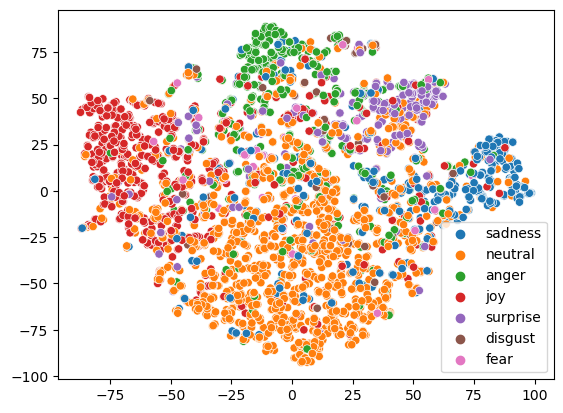

In [73]:
supcon_model.eval()

proj_val = []
targets_val = []

proj_train = []
targets_train = []

for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
    with torch.no_grad():
        batch = train_df_erc.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))

        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()
        try:
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.to(0),
                "attn_masks": att.to(0),
            }
        except:
            audio_input = None

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))

        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()]
        mult = mult[mult["label"].notna()]
        y_mult = torch.Tensor(lab_encoder.transform(mult["label"]))

        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]

        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}

        target = torch.cat([y_text, y_audio, y_mult])

        x = [sentences, audio_input, multimodal]

        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out = supcon_model(x)

            # Multimodal loss
            x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)

        proj_train.append(np.array(x_mult_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del x_mult_wide
        gc.collect()
        torch.cuda.empty_cache()
proj_train = np.concatenate(proj_train, axis=0)
targets_train = np.concatenate(targets_train, axis=0)

clf = FaissKNeighbors(k=128)
clf.fit(proj_train, np.array(targets_train, dtype=int))

supcon_model.eval()
preds = []
targets = []
css = 0.0

for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
    with torch.no_grad():

        multimodal_batch = test_df_erc.iloc[batch_indices[0]]

        audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}

        target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

        x = [None, None, multimodal]
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out = supcon_model(x)

            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)

        cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

        wide = np.array(out_x_wide.cpu())
        pred = clf.predict(wide)
        preds.append(pred)

        assert len(wide) == len(pred)

        proj_val.append(wide)
        targets_val.append(np.array(target.cpu()))
        css += np.sum(np.array(cs.cpu()))
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

proj_val = np.concatenate(proj_val, axis=0)
targets_val = np.concatenate(targets_val, axis=0)

preds = np.array(np.concatenate(preds, axis=0))

css = css / len(test_df_erc)

general_f1 = f1_score(targets_val, preds, average='weighted')
general_acc = accuracy_score(targets_val, preds)

print(f'Cosine Similarity between mods: {css}')

meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
plt.show()

In [74]:
train_df_erc

,text,label,path
0,The only one I know still love his parents. [B...,joy,/home/vmachado/Documents/multimodal-datasets/I...
1,The only one I know still love his parents. Ye...,neutral,/home/vmachado/Documents/multimodal-datasets/I...
2,Oh it's not bad thing it's good thing. You kno...,joy,/home/vmachado/Documents/multimodal-datasets/I...
3,"You know it's nice here, the air is sweet. You...",sadness,/home/vmachado/Documents/multimodal-datasets/I...
4,"You're not sorry you came? Not sorry, no. I c...",sadness,/home/vmachado/Documents/multimodal-datasets/I...
...,...,...,...
13723,That would be no. Come on. It doesn't taste ba...,neutral,/home/vmachado/Documents/multimodal-datasets/M...
13724,"Come on. It doesn't taste bad. Yeah, it's kind...",joy,/home/vmachado/Documents/multimodal-datasets/M...
13725,"Yeah, it's kinda sweet, sorta like, uh... Cant...",neutral,/home/vmachado/Documents/multimodal-datasets/M...
13726,Cantaloupe juice. Exactly. [BFR] You've tasted...,surprise,/home/vmachado/Documents/multimodal-datasets/M...


In [75]:
meld_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: True if "MELD" in x else False)].index

In [76]:
iemocap_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: False if "MELD" in x else True)].index

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train[meld_train_idx].mean(axis=0)
std_test = proj_train[meld_train_idx].std(axis=0)
clf = FaissKNeighbors(k=128)
clf.fit((proj_train[meld_train_idx]-mean_test)/std_test, np.array(targets_train[meld_train_idx], dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

from sklearn.metrics import classification_report

print(classification_report(targets_val[meld_idx], preds[meld_idx], digits=4, target_names=lab_encoder.classes_))

              precision    recall  f1-score   support

       anger     0.5112    0.3971    0.4470       345
     disgust     0.3548    0.1618    0.2222        68
        fear     0.0435    0.0200    0.0274        50
         joy     0.5756    0.6343    0.6036       402
     neutral     0.6980    0.8097    0.7497      1256
     sadness     0.4701    0.2644    0.3385       208
    surprise     0.5424    0.5231    0.5326       281

    accuracy                         0.6218      2610
   macro avg     0.4565    0.4015    0.4173      2610
weighted avg     0.5981    0.6218    0.6035      2610



In [78]:
len(targets_val[iemocap_idx])

1241

In [79]:
set(lab_encoder.inverse_transform(np.array(targets_val[iemocap_idx], dtype=int)))


{'anger', 'joy', 'neutral', 'sadness'}

In [80]:
df_iemocap_orig = pd.read_json("emotions.json").reset_index(drop=False)
df_iemocap_orig = pd.melt(df_iemocap_orig, id_vars=['index'], value_vars=['train', 'val', 'test']).dropna().drop(columns=["variable"]).rename(columns={"index":"id", "value": "orig_label"}).reset_index(drop=True)
df_iemocap_orig = df_iemocap_orig[df_iemocap_orig["orig_label"].notna() & (df_iemocap_orig["orig_label"] != "undecided")].reset_index(drop=True)
df_iemocap_orig

,id,orig_label
0,Ses01F_impro01_F000,neutral
1,Ses01F_impro01_F001,neutral
2,Ses01F_impro01_F002,neutral
3,Ses01F_impro01_F005,neutral
4,Ses01F_impro01_F006,frustration
...,...,...
7527,Ses05M_script03_2_M041,anger
7528,Ses05M_script03_2_M042,anger
7529,Ses05M_script03_2_M043,anger
7530,Ses05M_script03_2_M044,anger


In [81]:
def cleaning_shit(x):
    if "MELD" in x:
        return None
    x = x.replace("val/", "")
    x = x.replace("train/", "")
    x = x.replace("test/", "")
    l = len("/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/")
    return x[l:].replace(".wav", "")


In [82]:
#train_df_erc_iemocap = train_df_erc[train_df_erc["path"].apply(lambda x: True if "IEMOCAP" in x else False)]
train_df_erc["id"] = train_df_erc["path"].apply(cleaning_shit)
train_df_erc_iemocap = train_df_erc.dropna()
train_df_erc_iemocap = train_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner").dropna()
train_df_erc_iemocap

,text,label,path,id,orig_label
0,The only one I know still love his parents. [B...,joy,/home/vmachado/Documents/multimodal-datasets/I...,Ses01M_script01_3_M000,happiness
1,The only one I know still love his parents. Ye...,neutral,/home/vmachado/Documents/multimodal-datasets/I...,Ses01M_script01_3_F001,neutral
2,Oh it's not bad thing it's good thing. You kno...,joy,/home/vmachado/Documents/multimodal-datasets/I...,Ses01M_script01_3_M001,happiness
3,"You know it's nice here, the air is sweet. You...",sadness,/home/vmachado/Documents/multimodal-datasets/I...,Ses01M_script01_3_F003,sadness
4,"You're not sorry you came? Not sorry, no. I c...",sadness,/home/vmachado/Documents/multimodal-datasets/I...,Ses01M_script01_3_M002,sadness
...,...,...,...,...,...
3836,"Right. Um, Thanks for asking, though. I mean, ...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,Ses04M_impro08_M027,neutral
3837,"God, that's like a whole problem with like-- B...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,Ses04M_impro08_F027,neutral
3838,"if you ever come out to Montgomery, I mean, yo...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,Ses04M_impro08_F028,neutral
3839,"call up the Sprint call center and, uh, you kn...",neutral,/home/vmachado/Documents/multimodal-datasets/I...,Ses04M_impro08_M028,neutral


In [83]:
len(iemocap_train_idx)

3841

In [84]:
test_df_erc["id"] = test_df_erc["path"].apply(lambda x: x[len('/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/test/'):].replace(".wav", "")) 

In [ ]:
test_df_erc_iemocap = test_df_erc[test_df_erc["source"] == "iemocap"].reset_index(drop=True)
test_df_erc_iemocap

In [ ]:
test_df_erc_iemocap = test_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner")
test_df_erc_iemocap

In [ ]:
new_lab = LabelEncoder().fit(train_df_erc_iemocap["orig_label"])

In [ ]:
train_df_erc_iemocap["orig_label"].unique()

In [ ]:
test_df_erc_iemocap["orig_label"].unique()

In [ ]:
train_df_erc_iemocap

In [ ]:
test_df_erc_iemocap

In [ ]:
correct_labels_train = new_lab.transform(train_df_erc_iemocap["orig_label"])
correct_labels_test = new_lab.transform(test_df_erc_iemocap["orig_label"])

In [ ]:
correct_labels_train

In [86]:
lab_encoder.classes_

array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise'], dtype=object)

In [ ]:
test_df_erc[test_df_erc["source"] == "iemocap"]["label"].value_counts()

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train[iemocap_train_idx].mean(axis=0)
std_test = proj_train[iemocap_train_idx].std(axis=0)
clf = FaissKNeighbors(k=128)
clf.fit((proj_train[iemocap_train_idx]-mean_test)/std_test, np.array(targets_train[iemocap_train_idx], dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], preds[iemocap_idx], digits=4))

              precision    recall  f1-score   support

         0.0     0.7910    0.8235    0.8069       170
         3.0     0.9130    0.7602    0.8296       442
         4.0     0.6652    0.7865    0.7208       384
         5.0     0.8223    0.8122    0.8172       245

    accuracy                         0.7873      1241
   macro avg     0.7979    0.7956    0.7936      1241
weighted avg     0.8017    0.7873    0.7904      1241



In [ ]:
general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])



In [ ]:
general_f1_iemocap

In [ ]:
general_f1_meld

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], list(map(lambda x: x if x != 1 else 6, preds[iemocap_idx])), digits=4))

## 